# Sin Filtro (TP2 Orga2)

## Experimentos de Rombos

### Compilado de codigo

In [1]:
# Copio las imagenes
!cp -R ../src/tests/data img/

# Compilo con los diferentes niveles de optimización
!cd ../src && make clean && make
!cp ../src/build/tp2 tp2
!cd ../src && make C_OPT=O1 C_BIN=tp2_O1
!cp ../src/build/tp2 tp2_O1
!cd ../src && make C_OPT=O2 C_BIN=tp2_O2
!cp ../src/build/tp2 tp2_O2
!cd ../src && make C_OPT=O3 C_BIN=tp2_O3
!cp ../src/build/tp2 tp2_O3


rm -fr build/*
mkdir -p build
make -C helper
make[1]: Entering directory '/home/mnpanic/repositorios/exactas/tp2/src/helper'
cc -ggdb -Wall -Wno-unused-parameter -Wextra -std=c99 -no-pie -pedantic -m64 -O0 -march=native -c -o ../build/libbmp.o libbmp.c
cc -ggdb -Wall -Wno-unused-parameter -Wextra -std=c99 -no-pie -pedantic -m64 -O0 -march=native -c -o ../build/imagenes.o imagenes.c
cc -ggdb -Wall -Wno-unused-parameter -Wextra -std=c99 -no-pie -pedantic -m64 -O0 -march=native -c -o ../build/utils.o utils.c
cc -ggdb -Wall -Wno-unused-parameter -Wextra -std=c99 -no-pie -pedantic -m64 -O0 -march=native bmpdiff.c ../build/libbmp.o ../build/imagenes.o ../build/utils.o -o ../build/bmpdiff
make[1]: Leaving directory '/home/mnpanic/repositorios/exactas/tp2/src/helper'
make -C filters
make[1]: Entering directory '/home/mnpanic/repositorios/exactas/tp2/src/filters'
cc -ggdb -Wall -Wno-unused-parameter -Wextra -std=c99 -no-pie -pedantic -m64 -O0 -march=native -c -o ../build/Rombos.o Rombos.c
cc -g

### Imports

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
#!/usr/bin/env python3
!pwd
!python3 --version

#import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from IPython.display import Markdown, display
from IPython.display import clear_output

from subprocess import check_output

from ipywidgets import IntProgress, HTML, VBox

/home/mnpanic/repositorios/exactas/tp2/exp
Python 3.6.8


### Utilidades

In [3]:
def printmd(string):
    display(Markdown(string))

def logProgress(sequence, every=None, size=None, name='Items'):
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
        
def done():
    print("Done!\n\n✨\n  ⊂_ヽ\n 　 ＼＼ \n　　 ＼( ͡° ͜ʖ ͡°)\n　　　 >　⌒ヽ\n　　　/ 　 へ＼\n　　 /　　/　＼＼\n　　 ﾚ　ノ　　 ヽ_つ\n　　/　/\n　 /　/|\n　(　(ヽ\n　|　|、＼\n　| 丿 ＼ ⌒)\n　| | 　　) /\nノ )　　Lﾉ\n(_／)")
    
def rmse(errorCuadratico, n):
    return np.sqrt(1/n * errorCuadratico)

In [4]:
def box_plot(impls, title):
    ## Create boxplots
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    dataToPlot = [imp["cycles"] for imp in impls]

    # Create the boxplot
    ## add patch_artist=True option to ax.boxplot() 
    ## to get fill color
    bp = ax.boxplot(dataToPlot, patch_artist=True, showfliers=False)

    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#1b9e77' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

    ax.set_xticklabels([imp["label"] for imp in impls])

    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.set_title(title)

In [5]:
import subprocess

IMGS  = ["BigFish.bmp"]
# aspect ratio: 16:9
SIZES = ['8192x4800','4096x2400' ,'2048x1200','1024x600','512x300', '256x150', '128x75', '64x37', '32x18']
DIR = "img/"

# Robado sin verguenza de src/tests/1_generar_imagenes.py
for filename in IMGS:
    print(filename)
    for size in SIZES:
        print("  " + size)
        name = filename.split('.')
        file_in  = DIR + filename
        file_out = DIR + "/" + name[0] + "." + size + "." + name[1]
        resize = "convert -resize " + size + "! " + file_in + " " + file_out
        subprocess.call(resize, shell=True)
    print("")

BigFish.bmp
  8192x4800
  4096x2400
  2048x1200
  1024x600
  512x300
  256x150
  128x75
  64x37
  32x18



### Obtencion de datos

In [6]:
IMPS = {
    "asm":      {"impl": "asm", "bin": "tp2",    "label": "asm",
                 "cycles": [], "cycles_per_img": []},

    "asm_pclc": {"impl": "exp", "bin": "tp2",    "label": "asm (pclc)",
                 "cycles": [], "cycles_per_img": []},

    "c_O0":     {"impl": "c",   "bin": "tp2",    "label": "c O0",
                 "cycles": [], "cycles_per_img": []},

    "c_O1":     {"impl": "c",   "bin": "tp2_O1", "label": "c O1",
                 "cycles": [], "cycles_per_img": []},

    "c_O3":     {"impl": "c",   "bin": "tp2_O3", "label": "c O2",
                 "cycles": [], "cycles_per_img": []},

    "c_O2":     {"impl": "c",   "bin": "tp2_O2", "label": "c O3",
                 "cycles": [], "cycles_per_img": []},

}

IMGS = {
    #"ncfom":                "img/NoCountryForOldMen.bmp",
    #"wargames":             "img/Wargames.bmp",
    #"big_fish":             "img/BigFish.bmp",
    "big_fish_32x18":       "img/BigFish.32x18.bmp",
    "big_fish_64x37":       "img/BigFish.64x37.bmp",
    "big_fish_128x75":      "img/BigFish.128x75.bmp",
    "big_fish_256x150":     "img/BigFish.256x150.bmp",
    "big_fish_512x300":     "img/BigFish.512x300.bmp",
    "big_fish_1024x600":    "img/BigFish.1024x600.bmp",
    "big_fish_2048x1200":   "img/BigFish.2048x1200.bmp",
    "big_fish_4096x2400":   "img/BigFish.4096x2400.bmp",
    "big_fish_8192x4800":   "img/BigFish.8192x4800.bmp",
}


FILTER = "Rombos"
ITER   = "50"

def run(im, img:str, t:str=ITER):
    """Corre una implementacion y retorna el output."""
    # Quiero correr
    #  ./tp2 Rombos -i asm -t 100 img/puente.bmp
    return check_output(["./"+im["bin"], FILTER, "-i", im["impl"], "-t", t, img]).decode("utf-8")

def parse_cycles(out):
    """ Output esperado:
0    Procesando...
1      Filtro             : Rombos
2      Implementación     : C
3      Archivo de entrada : img/puente.bmp
4    Tiempo de ejecución:
5      Comienzo                          : 418148872718872
6      Fin                               : 418154435946972
7      # iteraciones                     : 100
8      # de ciclos insumidos totales     : 5563228100
9      # de ciclos insumidos por llamada : 55632280.000
    """
    return float(out.split('\n')[9].split(': ')[1])

#### Ciclos normales

In [7]:
for imp in logProgress(IMPS.keys(), name="Implementación"):
    for _ in logProgress(range(0, 100), name="Iteración"):
        out = run(IMPS[imp], t="20", img=IMGS["big_fish_1024x600"])
        cycles = parse_cycles(out)
        IMPS[imp]["cycles"].append(cycles)

done()

Done!

✨
  ⊂_ヽ
 　 ＼＼ 
　　 ＼( ͡° ͜ʖ ͡°)
　　　 >　⌒ヽ
　　　/ 　 へ＼
　　 /　　/　＼＼
　　 ﾚ　ノ　　 ヽ_つ
　　/　/
　 /　/|
　(　(ヽ
　|　|、＼
　| 丿 ＼ ⌒)
　| | 　　) /
ノ )　　Lﾉ
(_／)


#### Ciclos por imagen

In [21]:
ASM_IMPS = [name for name in IMPS.keys() if "asm" in name]
for imp in logProgress(ASM_IMPS, name="Implementación"):
    IMPS[imp]["cycles_per_img"] = []
    for img in logProgress(IMGS.values(), name="Imagen"):
        out = run(IMPS[imp], t="150", img=img)
        IMPS[imp]["cycles_per_img"].append(parse_cycles(out))
done()

Done!

✨
  ⊂_ヽ
 　 ＼＼ 
　　 ＼( ͡° ͜ʖ ͡°)
　　　 >　⌒ヽ
　　　/ 　 へ＼
　　 /　　/　＼＼
　　 ﾚ　ノ　　 ヽ_つ
　　/　/
　 /　/|
　(　(ヽ
　|　|、＼
　| 丿 ＼ ⌒)
　| | 　　) /
ノ )　　Lﾉ
(_／)


### Plots de datos

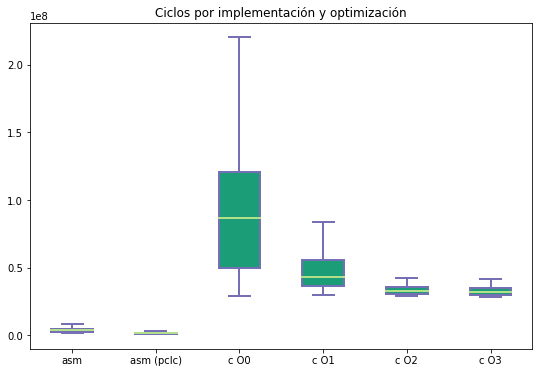

In [10]:
box_plot(IMPS.values(), "Ciclos por implementación y optimización")

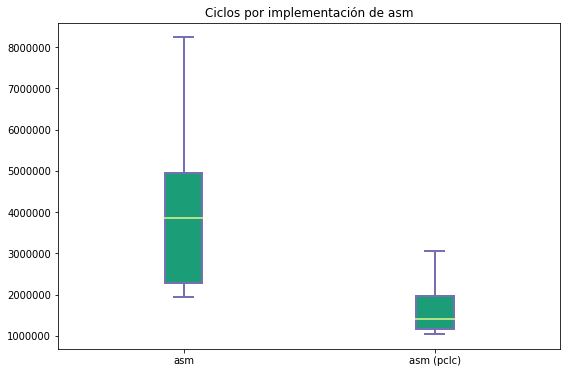

In [11]:
box_plot(
    [info for imp, info in IMPS.items() if "asm" in imp],
    "Ciclos por implementación de asm"
)

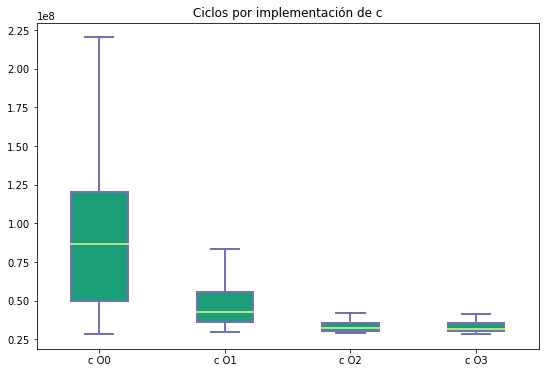

In [12]:
box_plot(
    [imp for imp in IMPS.values() if "c"==imp["impl"]],
    "Ciclos por implementación de c"
)

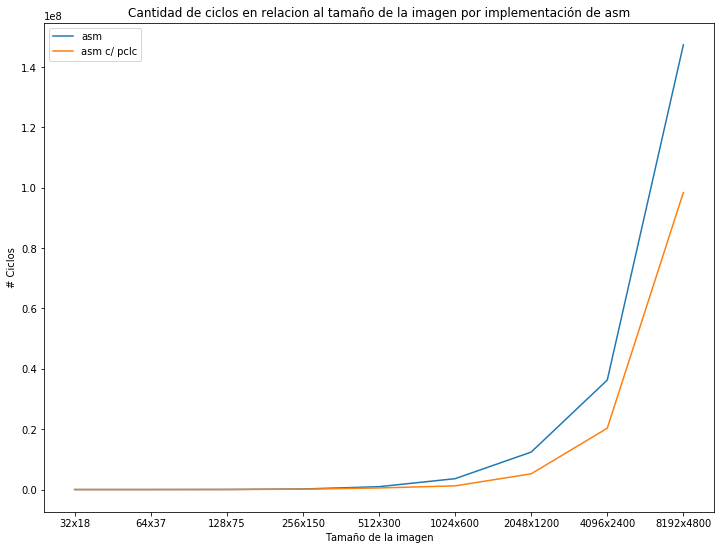

In [22]:
# key of fmt big_fish_128x75
sizes = [img.split('_')[2] for img in IMGS.keys()]
fig = plt.figure(1, figsize=(12, 9))
plt.plot(sizes, IMPS["asm"]["cycles_per_img"], figure=fig, label="asm")
plt.plot(sizes, IMPS["asm_pclc"]["cycles_per_img"], figure=fig, label="asm c/ pclc")
plt.legend()
plt.xlabel("Tamaño de la imagen")
plt.ylabel("# Ciclos")
plt.title("Cantidad de ciclos en relacion al tamaño de la imagen por implementación de asm")
plt.show()